In [1]:
# exploring options to optimise particle filter params
# by optimising for accuracy over realworld log

# log was taken using nav-stack to drive around the office, and intermittently logging ground truth poses manually
# throughout the run

In [2]:
from typing import List
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from cbl_particle_filter.filter import load_input_log
from cbl_particle_filter.carpet_map import load_map_from_png
from cbl_particle_filter.filter import Pose, CarpetBasedParticleFilter, offline_playback
from cbl_particle_filter.visualisation import plot_map

plt.rcParams['figure.figsize'] = [12, 8]
plt.rcParams['figure.dpi'] = 100 # 200 e.g. is really fine, but slower

In [3]:
log_dir = "/home/tfanselo/projects/personal/20210106_cbl/logs/20210415_pf_office_test/"
log_file = f"{log_dir}/localiser_input_log.pickle"
map_png = f"{log_dir}/office_map.png"

In [4]:
carpet = load_map_from_png(map_png, cell_size=0.5)

In [5]:
log = load_input_log(log_file)
start_pose = log[1][2]
print(start_pose)
log

Pose(x=6.334480285644531, y=3.237976312637329, heading=1.5368192195892334)


[(OdomMeasurement(dx=0, dy=0, dheading=0),
  Color(index=2, name='BEIGE', rgb=(241, 230, 218)),
  None),
 (None,
  None,
  Pose(x=6.334480285644531, y=3.237976312637329, heading=1.5368192195892334)),
 (OdomMeasurement(dx=0, dy=0, dheading=0),
  Color(index=2, name='BEIGE', rgb=(241, 230, 218)),
  None),
 (OdomMeasurement(dx=-0.084298275411129, dy=0.0048685222864151, dheading=-0.1097223311662674),
  Color(index=2, name='BEIGE', rgb=(241, 230, 218)),
  None),
 (OdomMeasurement(dx=-0.031697278810864135, dy=0.001954084128733925, dheading=-0.14566586911678314),
  Color(index=2, name='BEIGE', rgb=(241, 230, 218)),
  None),
 (OdomMeasurement(dx=-0.02017510261255754, dy=0.0012630403656688285, dheading=-0.1229645311832428),
  Color(index=2, name='BEIGE', rgb=(241, 230, 218)),
  None),
 (OdomMeasurement(dx=-0.019920793985359935, dy=0.0015755742220226812, dheading=-0.16269174218177795),
  Color(index=2, name='BEIGE', rgb=(241, 230, 218)),
  None),
 (OdomMeasurement(dx=-0.007769489719555342, dy=0.

In [6]:
def perform_playback(
    log,
    carpet_map,
    seed_pose,
    pf_params=dict(),
    ):
    """
    Localise over given log, returning a dataframe of localised poses and
    ground truth
    """
    
    np.random.seed(123)
    
    localised_poses = offline_playback(
        input_data = log,
        carpet = carpet,
        seed_pose = seed_pose,
        use_seed_messages=False,
        **pf_params,
    )    
    
    # convert results to dataframe
    ground_truth_poses = [gt_pose for _, _, gt_pose in log]

    df_data = []
    for ground_truth_pose, localised_pose in zip(ground_truth_poses, localised_poses):
        if ground_truth_pose:
            gt_x = ground_truth_pose.x
            gt_y = ground_truth_pose.y
        else:
            gt_x = float("nan")
            gt_y = float("nan")
            
        df_data.append({
            "gt_x":gt_x,
            "gt_y":gt_y,
            "loc_x":localised_pose.x,
            "loc_y":localised_pose.y,
        })
    return pd.DataFrame(df_data)

def plot_results(results_df:pd.DataFrame):    
    plot_map(carpet, show=False)
    plt.plot(results_df.loc_x, results_df.loc_y, color='tab:green', marker='o',markersize=3)
    plt.plot(results_df.gt_x, results_df.gt_y, color='tab:orange', marker='o', linewidth=2)

    plt.axis('off')
    plt.legend(['ground truth', 'particle filter output'])
    plt.show()
    
def get_playback_error(
    log,
    carpet_map,
    seed_pose,
    plot=False,
    print_inidividual_errors=False,
    pf_params=dict()
    ):
    """
    Report sum squared position error for playback of the given log
    """
    results_df = perform_playback(
        log,
        carpet_map,
        seed_pose,
        pf_params=pf_params,
    )
    ground_truth_results = results_df[~np.isnan(results_df.gt_x)].copy()
    ground_truth_results.loc[:,"position_error"] = np.linalg.norm(
        np.vstack(
            [
                ground_truth_results.loc_x - ground_truth_results.gt_x,
                ground_truth_results.loc_y - ground_truth_results.gt_y
            ]
        ),axis=0
    )
    if print_inidividual_errors:
        print(ground_truth_results)
        
    sum_squared_error = sum(np.power(ground_truth_results["position_error"],2))
    
    if plot:
        plot_results(results_df)

    return sum_squared_error

         gt_x      gt_y     loc_x     loc_y  position_error
1    6.334480  3.237976  6.348165  3.369816        0.132548
151  4.985723  5.706280  5.122813  5.510669        0.238867
189  5.604718  7.875151  5.822466  7.787360        0.234780
243  3.295976  3.687562  3.255492  3.745586        0.070752
295  6.163623  3.818021  6.199973  3.669263        0.153135


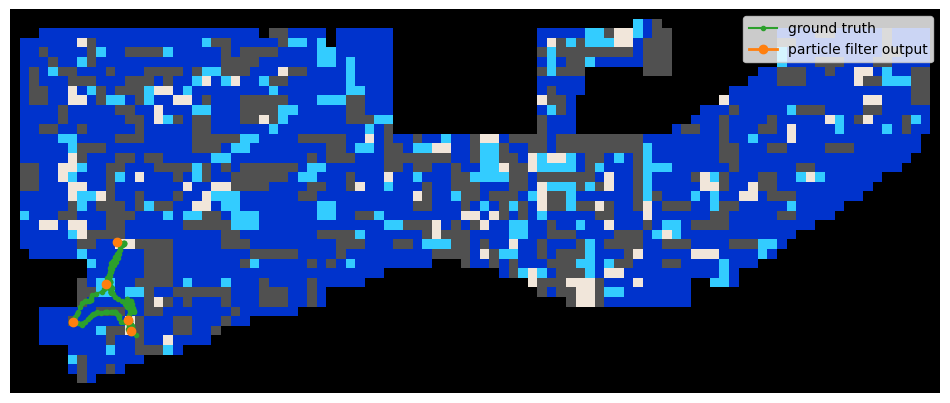

0.15820398428789234

In [7]:
get_playback_error(
    log,
    carpet,
    seed_pose=start_pose,
    plot=True,
    print_inidividual_errors=True,
    pf_params=dict(
        resample_proportion=0,
        weight_fn_p=0.9,
        odom_pos_noise=0.05,
        odom_heading_noise=0.05,
        n_particles=500,
    ),
)

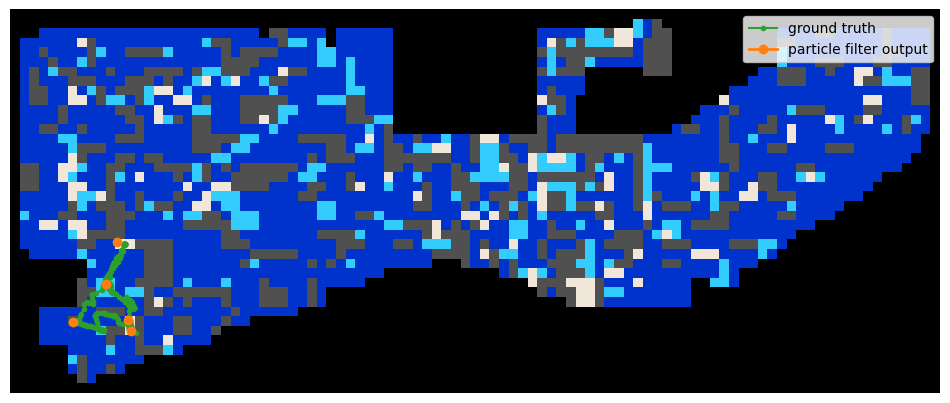

0.9690946104775113

In [8]:
get_playback_error(
    log,
    carpet,
    seed_pose=start_pose,
    plot=True,
    pf_params=dict(
        resample_proportion=0,
        weight_fn_p=0.9,
        odom_pos_noise=0.1,
        odom_heading_noise=0.05,
        n_particles=500,
    )
)

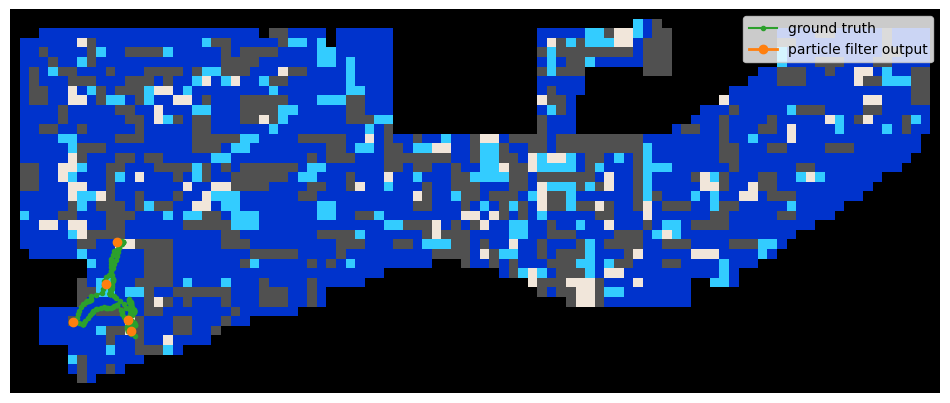

0.22240595348698258

In [9]:
get_playback_error(
    log,
    carpet,
    seed_pose=start_pose,
    plot=True,
    pf_params=dict(
        resample_proportion=0,
        weight_fn_p=0.9,
        odom_pos_noise=0.01,
        odom_heading_noise=0.05,
        n_particles=500,
    ),
)

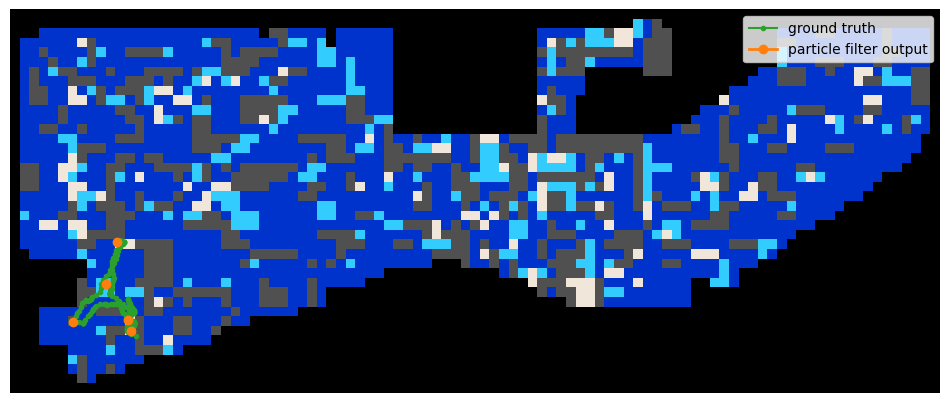

0.23347537647490452

In [10]:
get_playback_error(
    log,
    carpet,
    seed_pose=start_pose,
    plot=True,
    pf_params=dict(
        resample_proportion=0,
        weight_fn_p=0.9,
        odom_pos_noise=0.0,
        odom_heading_noise=0.05,
        n_particles=500,
    )
)

In [11]:
# Try some parameter value sweeps to look for minima

In [12]:
def test_parameter_range(parameter_name:str, parameter_values:List):
    for parameter_value in parameter_values:
        pf_params = {parameter_name:parameter_value}
        error = get_playback_error(
            log,
            carpet,
            seed_pose=start_pose,
            plot=False,
            pf_params=pf_params,        
        )
        print(f"{parameter_name}={parameter_value},\t{error=}")

In [13]:
test_parameter_range("odom_pos_noise",[0, 0.005, 0.01, 0.02, 0.1, 1.0])

odom_pos_noise=0,	error=0.24954967383319032
odom_pos_noise=0.005,	error=0.23670085525022877
odom_pos_noise=0.01,	error=0.2694076862168211
odom_pos_noise=0.02,	error=0.22060437057392226
odom_pos_noise=0.1,	error=0.38533253538273277
odom_pos_noise=1.0,	error=218.07071700073678


In [14]:
# looks like a minimum for odom_pos_noise around 0.01

In [15]:
test_parameter_range("odom_heading_noise",[0, 0.005, 0.01, 0.02, 0.1, 1.0])

odom_heading_noise=0,	error=0.2470198896521255
odom_heading_noise=0.005,	error=0.2349823187637111
odom_heading_noise=0.01,	error=0.2741542558104321
odom_heading_noise=0.02,	error=0.21849228008632393
odom_heading_noise=0.1,	error=0.23925984086817112
odom_heading_noise=1.0,	error=47.275824377396766


In [16]:
# odom_heading_noise also looks good around 0.01

# Note that odometry in this case is generated by the gazebo_ros_diff_drive plugin, which does not appear to 
# add any noise to the simulated output
# https://github.com/ros-simulation/gazebo_ros_pkgs/blob/kinetic-devel/gazebo_plugins/src/gazebo_ros_diff_drive.cpp
# This could lead to significantly different results between simulation and reality.
# Relevant to adding noise to gazebo odom:
# https://blog.lxsang.me/post/id/16

In [17]:
test_parameter_range("resample_proportion",[0, 0.01, 0.1, 1.0])

resample_proportion=0,	error=0.20635065090286045
resample_proportion=0.01,	error=186.50435052446142
resample_proportion=0.1,	error=1398.060079094124
resample_proportion=1.0,	error=1294.5887213240171


In [18]:
# resample proportion doesn't appear to help at all.
# My assumption would be that this resampling increases the chance of recovering from loss of localisation,
# at the expense of degrading accuracy in the normal case.

In [19]:
test_parameter_range("weight_fn_p",[0.5, 0.8, 0.9, 0.95, 0.99, 1.0])

weight_fn_p=0.5,	error=2.3240134424605023
weight_fn_p=0.8,	error=0.21886845116671996
weight_fn_p=0.9,	error=0.15820398428789234
weight_fn_p=0.95,	error=0.20635065090286045
weight_fn_p=0.99,	error=0.27520022178312964


/home/tfanselo/projects/personal/20210106_cbl/carpet_localisation/venv/lib/python3.8/site-packages/pfilter/pfilter.py:347: RuntimeWarning: divide by zero encountered in log
  self.weight_entropy = np.sum(self.weights * np.log(self.weights))
/home/tfanselo/projects/personal/20210106_cbl/carpet_localisation/venv/lib/python3.8/site-packages/pfilter/pfilter.py:347: RuntimeWarning: invalid value encountered in multiply
  self.weight_entropy = np.sum(self.weights * np.log(self.weights))


weight_fn_p=1.0,	error=0.25606997385814356


In [20]:
# notice multiple local minima, at p=0.95 and p=1.0
# I'd guess these parameter sweeps are partially susceptible to 
# noise / edge cases for particular parameterisations.
# out of interest, plot the last three trajectories, to see what goes wrong when p=0.99

weight_fn_p=0.95


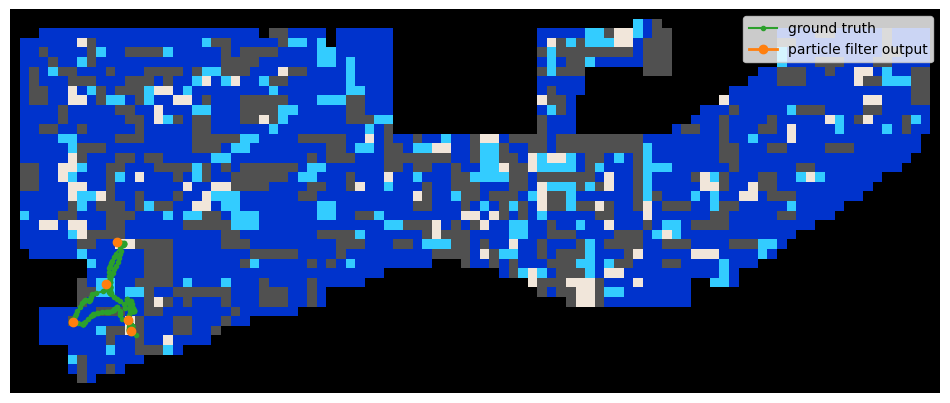

weight_fn_p=0.99


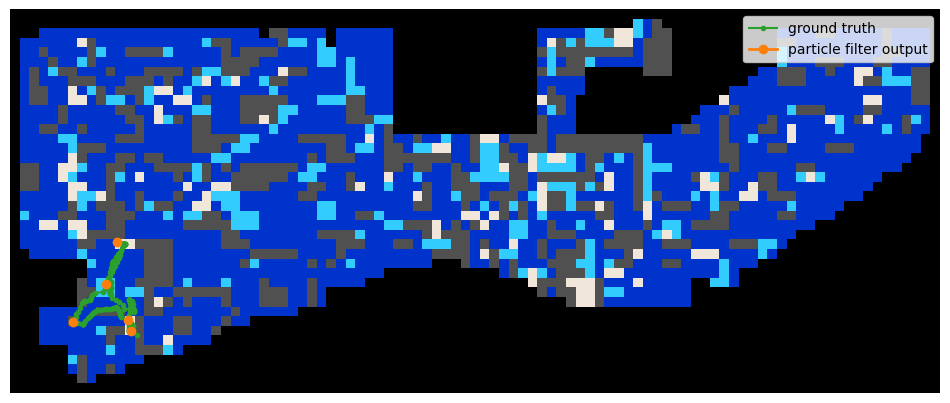

weight_fn_p=1.0


/home/tfanselo/projects/personal/20210106_cbl/carpet_localisation/venv/lib/python3.8/site-packages/pfilter/pfilter.py:347: RuntimeWarning: divide by zero encountered in log
  self.weight_entropy = np.sum(self.weights * np.log(self.weights))
/home/tfanselo/projects/personal/20210106_cbl/carpet_localisation/venv/lib/python3.8/site-packages/pfilter/pfilter.py:347: RuntimeWarning: invalid value encountered in multiply
  self.weight_entropy = np.sum(self.weights * np.log(self.weights))


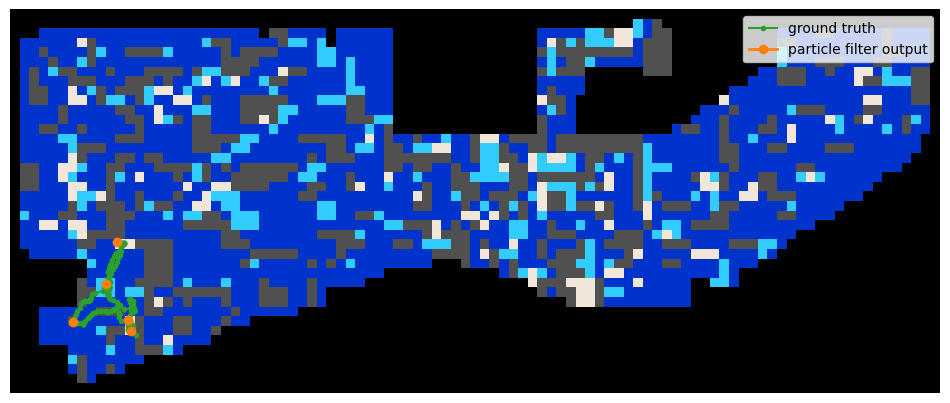

In [21]:
for weight_fn_p in [0.95, 0.99, 1.0]:
    print(f"{weight_fn_p=}")
    get_playback_error(
        log,
        carpet,
        seed_pose=start_pose,
        plot=True,
        pf_params=dict(
            weight_fn_p=weight_fn_p,
        )
    )

In [22]:
# couldnt see any obvious differences in the trajectories.

In [23]:
test_parameter_range("n_particles",[10, 100, 1000, 10000])

n_particles=10,	error=81.03104891814064
n_particles=100,	error=0.26979157423687977
n_particles=1000,	error=0.24759234330588586
n_particles=10000,	error=0.22040730193846583


In [24]:
# more particles = better, but also slower. 10k took quite a while to complete

In [25]:
# more focused particle number testing
test_parameter_range("n_particles",[100, 200, 300, 500, 700, 1000])

n_particles=100,	error=0.26979157423687977
n_particles=200,	error=0.2190997045903623
n_particles=300,	error=0.21025101724790743
n_particles=500,	error=0.20635065090286045
n_particles=700,	error=0.21528814269842608
n_particles=1000,	error=0.24759234330588586


In [26]:
# anything over 200 does not appear to have a large effect on error, although I'd still want to keep the number
# high for general robustness (don't want to overfit this limited dataset)

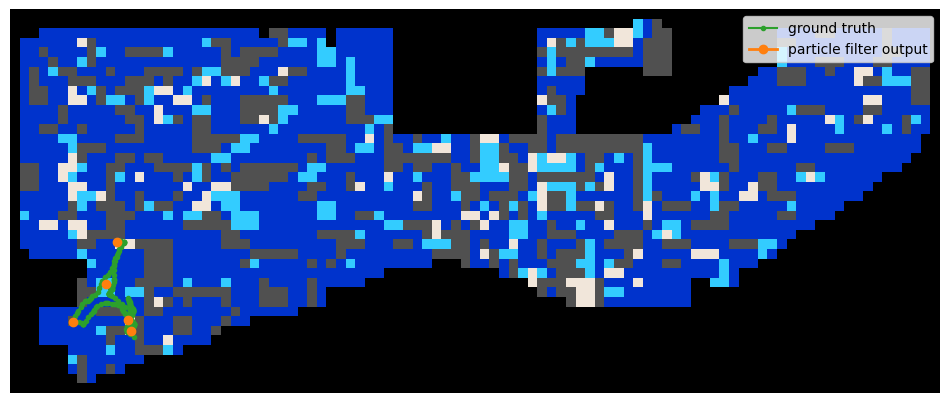

0.23202737918761168

In [27]:
# Test current best guess parameters

get_playback_error(
        log,
        carpet,
        seed_pose=start_pose,
        plot=True,
        pf_params=dict(
            odom_pos_noise=0.01,
            odom_heading_noise=0.01,
            resample_proportion=0,
            weight_fn_p = 0.95,
            n_particles = 500
        )
    )

In [28]:
# looks pretty good, except for a position jump around the start of the trajectory.
# I'm also concerned about overfitting to simulated data.
# Will test these parameters in real world and observe performance.